<a id="0"></a> <br>
 # Table of Contents  
1. [Set up](#1)     
1. [Inference plots](#2)
1. plots, 3 kinds
    1. [trajectory plots, color](#3)
    1. [trajectory plots, spike protein mutations](#4)
    1. [trajectory plots, structural protein mutations](#5)
1. gap handling
    1. [gap handling, struct mutations](#6)
    1. [gap handling, spike mutations](#7)

<a id="1"></a>
### packages, global variables, loading
#### run cell below to intialize

In [18]:
# packages

import sys, os
import re
import datetime
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import linregress

# directories

#username         = 'YOUR_LOCAL_PATH' 

home_dir           = os.path.join(username, 'paper-epi-backprojection/data/analysis-visualization')
data_dir           = os.path.join(username, 'paper-epi-backprojection/data/SC2_BP_Data')
inf_plot_home      = os.path.join(home_dir, 'inference-plotting')
inf_plot_bp_home   = os.path.join(home_dir, 'inference-plotting-bp')

# helper function: date

def get_day(day):
    ref_date = datetime.date(2020, 1, 1)
    target = ref_date + datetime.timedelta(day)
    return(target.strftime("%m-%d-%y"))

# helper function: sizing

def cm2inch(x): 
    return float(x)/2.54

# helper function: legend

def extract_numeric(arr):
    numeric_values = []
    for item in arr:
        match = re.match(r'(\d+)', str(item))
        if match:
            numeric_values.append(int(match.group(1)))
    return np.array(numeric_values)

# global variables: paper size

SINGLE_COLUMN = cm2inch(8.8)
DOUBLE_COLUMN = cm2inch(18.0)

# global variables: colormap

cmap = cm.get_cmap('Spectral')
rgba1 = cmap(0)
rgba2 = cmap(0.25)
rgba3 = cmap(0.5)
rgba4 = cmap(0.75)
rgba5 = cmap(0.9)
rgba6 = cmap(0.99) 

# global variables: size and font parameters

FONTFAMILY    = 'Arial'
SIZESUBLABEL  = 8
SIZE_LABEL     = 6
SIZE_TICK      = 6
SMALLSIZEDOT  = 6.
SIZELINE      = 0.6
AXES_FONTSIZE = 6
AXWIDTH       = 0.4

# loading function

def load_npz_covar(path):
    
    #path = targeted country
    
    npz_files = [f for f in os.listdir(path) if f != ".DS_Store"]
    
    time_l = []
    count_l = []

    for file in sorted(npz_files):
        filepath = os.path.join(path, file)
        data = np.load(filepath, allow_pickle=True)
        times = data['times']
        counts = data['counts']
        refs = data['ref_sites']
        time_l.append(times)
        count_l.append(counts)

    x = np.concatenate(time_l)
    y = np.concatenate(count_l)
    z = refs
    
    return x, y, z

<a id="2"></a>
### inference plot functions
#### initialize for gridspec placement below

In [19]:
def plot_inf(ax, x, y, index):
    mpl.rc('font', family='Arial')

    ax.plot(x, y, 'o', color=rgba1, markersize=0.4)

    ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color=rgba6, linewidth=0.8)
    
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, color=rgba5, linestyle='dashed', linewidth=0.6)

    ax.set_xlim(xmin=-0.03, xmax=0.05)
    ax.set_ylim(ymin=-0.03, ymax=0.05)

    x_title = 'Inferred selection coefficient, ' + r'$\hat{s}$' + '\nSample collections'
    y_title = 'Inferred selection coefficient, ' + r'$\hat{s}$' + '\nInferred infections'
    ax.set_xlabel(xlabel=x_title, font='Arial', size=6, labelpad=10, math_fontfamily='stixsans')
    ax.set_ylabel(ylabel=y_title, font='Arial', size=6, labelpad=10, math_fontfamily='stixsans')

    ax.set_aspect('equal', adjustable='box')
    ax.tick_params(axis='x', labelsize=6, width=0.6)
    ax.tick_params(axis='y', labelsize=6, width=0.6)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Arial')
        
    for line in ['top', 'right']:
        ax.spines[line].set_linewidth(0.5)
    for line in ['left', 'bottom']:
        ax.spines[line].set_linewidth(0.5)
        
    lr = linregress(x, y)
        
    custom_shapes = [Line2D([0], [0], marker='o', color='w', alpha=0),
                     Line2D([0], [0], marker='o', color='w', alpha=0)]    
    custom_labels = ['m:  ' + str(round(lr.slope, 3)), 'R:  ' + str(round(lr.rvalue, 3))]
    
    ax.legend(custom_shapes, custom_labels, loc='lower right', fontsize=6, labelcolor=rgba6, frameon=False)

    print(linregress(x, y))

<a id="3"></a>
### trajectory plots (color)

Enter the start date as integer or 0 for entire trajectory: 0
Enter the end date as integer or 0 for entire trajectory: 0
LinregressResult(slope=2.456811489160354, intercept=7.75992765584201e-05, rvalue=0.8859872737789823, pvalue=0.0, stderr=0.02580489136050099, intercept_stderr=1.9040695261985683e-05)


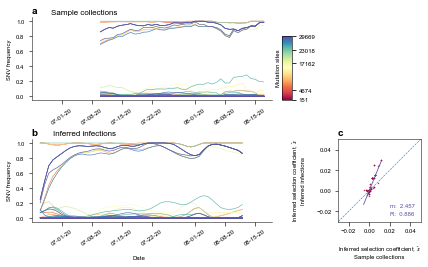

In [20]:
def plot_covar_color(ax, x, y, z, plot_label, start_time, end_time, scalar_map):
    
    # set font param
    mpl.rc('font', family='Arial')
    
    csv_file = os.path.join(data_dir, 'ref-index-2024-01-26.csv')
    ref = pd.read_csv(csv_file)
    df = pd.DataFrame(ref)
    sites = z
    
    NUC     = ['-', 'A', 'C', 'G', 'T']
    new_labels = []
    for i in sites:
        for j in NUC:
            new_labels.append(str(i) + '-' + j)      
    
    index_drop = []
    ref_index_set = set(map(str, sites))
    df = df[df['ref_index'].astype(str).isin(ref_index_set)]
    df = df[~df['ref_index'].isin(index_drop)]
    df['combined'] = df['ref_index'].str.cat(df['nucleotide'], sep='-')

    ref_labels = []
    for i in enumerate(df['combined']):
        ref_labels.append(i[1])
    st = set(ref_labels)
    indices = [i for i, e in enumerate(new_labels) if e in st]

    ref_date = datetime.date(2020, 1, 1)
    x_days = [int(day) for day in x]
    x_dates = [ref_date + datetime.timedelta(days=day) for day in x_days] 
    
    num_lines = y.shape[1]

    for i in range(num_lines):
        if i not in indices:
            y_line = y[:, i]
            color = scalar_map.to_rgba(i)
            ax.plot(x_dates, y_line, linewidth=0.6, color=color)
    plt.subplots_adjust(bottom=0.15)
    
    #ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    
    ax.tick_params(axis='x', labelsize=6, rotation=35, width=0.6)
    ax.tick_params(axis='y', labelsize=6, width=0.6)
    
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Arial')

    #fig.autofmt_xdate()
    
    for line in ['top', 'right']:
        ax.spines[line].set_visible(False)
    for line in ['left', 'bottom']:
        ax.spines[line].set_linewidth(0.5)
    
    plt.setp(ax.get_xticklabels(), ha='center')
    
    start_date = ref_date + datetime.timedelta(int(start_time))
    end_date = ref_date + datetime.timedelta(int(end_time))
    
    ax.set_xlim(start_date, end_date)
    
    ax.set_title(plot_label, x=0.22, y=0.97, fontsize=8)

def figure_color(index, home_dir):
    
    # crawl through directory to plot each region's trajectories
    un_covar_home = os.path.join(home_dir, 'genome-covar')
    bp_covar_home = os.path.join(home_dir, 'bp-covar')
    # from inf_figure function
    sorted_inf_files = sorted(f for f in os.listdir(inf_plot_home) if f != ".DS_Store")
    sorted_bp_files = sorted(f for f in os.listdir(inf_plot_bp_home) if f != ".DS_Store")
    # crawling (cont.)
    un_cov_dir = []
    bp_cov_dir = []

    for d in os.listdir(un_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(un_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            un_cov_dir.append(plot_dir)

    for d in os.listdir(bp_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(bp_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            bp_cov_dir.append(plot_dir)

    un_cov_dir = sorted(un_cov_dir)
    bp_cov_dir = sorted(bp_cov_dir)
    
    # inf file loading    
    inf_file = sorted_inf_files[index]
    x = np.load(os.path.join(inf_plot_home, inf_file), allow_pickle=True)

    inf_bp_file = sorted_bp_files[index]
    y = np.load(os.path.join(inf_plot_bp_home, inf_bp_file), allow_pickle=True)
    
    un_sel = x['selection']
    bp_sel = y['selection']
    
    # covar loading

    un_sel_x, un_sel_y, un_ref_z = load_npz_covar(un_cov_dir[index])
    bp_sel_x, bp_sel_y, bp_ref_z = load_npz_covar(bp_cov_dir[index])
    
    # gridspec parameters
    
    fig = plt.figure(figsize=(DOUBLE_COLUMN, DOUBLE_COLUMN/2))
    gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.14, hspace=0.48)
    
    # Subplots for covariate plots
    ax1 = plt.subplot(gs[0, 0])  # Top-left plot (wide)
    ax2 = plt.subplot(gs[1, 0])  # Bottom-left plot (wide)
    ax3 = plt.subplot(gs[1, 2])  # Bottom-right square plot
    
    ax1.set_xlabel('a', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax2.set_xlabel('b', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax1.xaxis.set_label_position('top')
    ax2.xaxis.set_label_position('top')
    
    ax1.set_ylabel('SNV frequency', font='Arial', size=6)
    ax2.set_ylabel('SNV frequency', font='Arial', size=6)
    
    #ax3.set_xlabel('c', font='Arial', fontweight='bold', size=10, labelpad=20, loc='left')
    #ax3.xaxis.set_label_position('top')

    num_lines = un_sel_y.shape[1]
    cmap = plt.get_cmap('Spectral')
    norm = plt.Normalize(0, num_lines - 1)
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)
    
    start = int(input("Enter the start date as integer or 0 for entire trajectory: "))
    end = int(input("Enter the end date as integer or 0 for entire trajectory: "))
    
    if start == 0:
        start = min(min(un_sel_x), min(bp_sel_x)) - 2 # 10 for longer traj to make fig look nice
    if end == 0:
        end = max(max(un_sel_x), max(bp_sel_x)) + 2

    plot_covar_color(ax1, un_sel_x, un_sel_y, un_ref_z, f'Sample collections', start, end, scalar_map)
    plot_covar_color(ax2, bp_sel_x, bp_sel_y, bp_ref_z, f'Inferred infections', start, end, scalar_map)
    
    plot_inf(ax3, un_sel, bp_sel, index)
    
    # shared colorbar (next to ax1)
    ref_sites = extract_numeric(un_ref_z)
    percentiles = np.percentile(ref_sites, [0, 25, 50, 75, 100])
    norm_cbar = Normalize(vmin=min(ref_sites), vmax=max(ref_sites))
    scalar_map = cm.ScalarMappable(norm=norm_cbar, cmap=cmap)
    cax = fig.add_axes([0.59, 0.578, 0.02, 0.25])
    cbar = fig.colorbar(scalar_map, cax=cax)
    
    cbar.set_label('Mutation sites', font='Arial', size=6, labelpad=-40)
    cbar.set_ticks(percentiles)
    cbar.set_ticklabels([f'{int(p)}' for p in percentiles])
    cbar.outline.set_linewidth(0.6)

    for label in cbar.ax.get_yticklabels():
        label.set_fontname('Arial')
        label.set_fontsize(6)
    
    fig.supxlabel('Date', fontsize=6, y=-0.05, x=0.31)
    fig.supylabel('c', font='Arial', fontweight='bold', fontsize=10, y=0.45, x=0.70,rotation=0)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=0.8)
    
    #save_path = username + f'/paper-epi-backprojection/figures/supplementary_case_{index}_color_date_rescale_3.pdf'
    #print(f"saving plot to: {save_path}")
    #plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    return fig

fig = figure_color(13, home_dir)

<a id="4"></a>
### trajectory plots (spike protein vs. all other mutations)

Enter the start date as integer or 0 for entire trajectory: 0
Enter the end date as integer or 0 for entire trajectory: 0
LinregressResult(slope=0.8791735469040443, intercept=3.604983996389051e-05, rvalue=0.819587457575753, pvalue=0.0, stderr=0.009508563727286482, intercept_stderr=1.0998003865618116e-05)


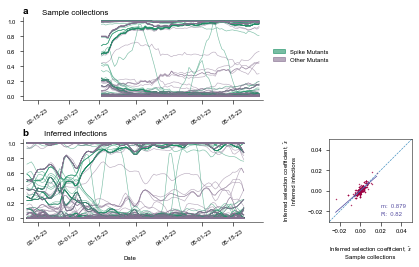

In [17]:
def plot_covar_spike(ax, x, y, z, plot_label, start_time, end_time, scalar_map):
    
    # set font param
    mpl.rc('font', family='Arial')
    
    csv_file = os.path.join(data_dir, 'ref-index-2024-01-26.csv')
    ref = pd.read_csv(csv_file)
    df = pd.DataFrame(ref)
    sites = z
    
    NUC     = ['-', 'A', 'C', 'G', 'T']
    new_labels = []
    for i in sites:
        for j in NUC:
            new_labels.append(str(i) + '-' + j)      
    
    index_drop = []
    ref_index_set = set(map(str, sites))
    df = df[df['ref_index'].astype(str).isin(ref_index_set)]
    df = df[~df['ref_index'].isin(index_drop)]
    df['combined'] = df['ref_index'].str.cat(df['nucleotide'], sep='-')

    ref_labels = []
    for i in enumerate(df['combined']):
        ref_labels.append(i[1])
    st = set(ref_labels)
    indices = [i for i, e in enumerate(new_labels) if e in st]

    ref_date = datetime.date(2020, 1, 1)
    x_days = [int(day) for day in x]
    x_dates = [ref_date + datetime.timedelta(days=day) for day in x_days] 
    
    num_lines = y.shape[1]
    
    for i in range(num_lines):
        site_label = new_labels[i]
        # handles reference genome insertion characters (22203a-y)
        if isinstance(site_label, str):
            site_value = int(re.sub(r'\D', '', site_label))
        else:
            site_value = int(site_label)
        
        ### comment one or other out
        # binary based on spike protein sites
        col = 'xkcd:viridian' if (21562 <= site_value < 25384) else 'xkcd:grayish purple'
        
        if i not in indices:
            x_line = x
            y_line = y[:, i]
            ax.plot(x_dates, y_line, linewidth=0.6, color=col, alpha=0.6)

    #plt.subplots_adjust(bottom=0.15)
    
    #ax.set_ylabel('Allele frequency', font='Arial', size=6, labelpad=10)
    
    #ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    
    ax.tick_params(axis='x', labelsize=6, rotation=35, width=0.6)
    ax.tick_params(axis='y', labelsize=6, width=0.6)
    
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Arial')

    #fig.autofmt_xdate()
    
    for line in ['top', 'right']:
        ax.spines[line].set_visible(False)
    for line in ['left', 'bottom']:
        ax.spines[line].set_linewidth(0.5)
    
    plt.setp(ax.get_xticklabels(), ha='center')
    
    start_date = ref_date + datetime.timedelta(int(start_time))
    end_date = ref_date + datetime.timedelta(int(end_time))
    
    ax.set_xlim(start_date, end_date)
    
    ax.set_title(plot_label, x=0.22, y=0.97, fontsize=8)

def figure_spike(index, home_dir):
    
    # crawl through directory to plot each region's trajectories
    un_covar_home = os.path.join(home_dir, 'genome-covar')
    bp_covar_home = os.path.join(home_dir, 'bp-covar')
    # from inf_figure function
    sorted_inf_files = sorted(f for f in os.listdir(inf_plot_home) if f != ".DS_Store")
    sorted_bp_files = sorted(f for f in os.listdir(inf_plot_bp_home) if f != ".DS_Store")
    # crawling (cont.)
    un_cov_dir = []
    bp_cov_dir = []

    for d in os.listdir(un_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(un_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            un_cov_dir.append(plot_dir)

    for d in os.listdir(bp_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(bp_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            bp_cov_dir.append(plot_dir)

    un_cov_dir = sorted(un_cov_dir)
    bp_cov_dir = sorted(bp_cov_dir)
    
    # inf file loading    
    inf_file = sorted_inf_files[index]
    x = np.load(os.path.join(inf_plot_home, inf_file), allow_pickle=True)

    inf_bp_file = sorted_bp_files[index]
    y = np.load(os.path.join(inf_plot_bp_home, inf_bp_file), allow_pickle=True)
    
    un_sel = x['selection']
    bp_sel = y['selection']
    
    # covar loading

    un_sel_x, un_sel_y, un_ref_z = load_npz_covar(un_cov_dir[index])
    bp_sel_x, bp_sel_y, bp_ref_z = load_npz_covar(bp_cov_dir[index])
    
    # gridspec parameters
    
    fig = plt.figure(figsize=(DOUBLE_COLUMN, DOUBLE_COLUMN/2))
    #gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.3, hspace=0.5)
    gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.14, hspace=0.48)
    # Subplots for covariate plots
    ax1 = plt.subplot(gs[0, 0])  # Top-left plot (wide)
    ax2 = plt.subplot(gs[1, 0])  # Bottom-left plot (wide)
    ax3 = plt.subplot(gs[1, 2])  # Bottom-right square plot
    
    ax1.set_xlabel('a', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax2.set_xlabel('b', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax1.xaxis.set_label_position('top')
    ax2.xaxis.set_label_position('top')

    num_lines = un_sel_y.shape[1]
    cmap = plt.get_cmap('Spectral')
    norm = plt.Normalize(0, num_lines - 1)
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)
    
    start = int(input("Enter the start date as integer or 0 for entire trajectory: "))
    end = int(input("Enter the end date as integer or 0 for entire trajectory: "))
    
    if start == 0:
        start = min(min(un_sel_x), min(bp_sel_x)) - 2 # 10 for longer traj to make fig look nice
    if end == 0:
        end = max(max(un_sel_x), max(bp_sel_x)) + 2

    plot_covar_spike(ax1, un_sel_x, un_sel_y, un_ref_z, f'Sample collections', start, end, scalar_map)
    plot_covar_spike(ax2, bp_sel_x, bp_sel_y, bp_ref_z, f'Inferred infections', start, end, scalar_map)
    
    plot_inf(ax3, un_sel, bp_sel, index)
    
    # legend, custom
    
    spike_patch = mpatches.Patch(color='xkcd:viridian', label='Spike Mutants', alpha = 0.6)
    other_patch = mpatches.Patch(color='xkcd:grayish purple', label='Other Mutants', alpha = 0.6)
    handles = [spike_patch, other_patch]

    #fig.legend(handles=handles, loc='center right', bbox_to_anchor=(1.22, 0.5), ncol=1, frameon=False,fontsize=6)  # Legend on the right side
    
    fig.legend(handles=handles, loc='center right', bbox_to_anchor=(0.71, 0.75), ncol=1, fontsize=6, frameon=False)  # Legend on the right side

    fig.supxlabel('Date', fontsize=6, y=-0.05, x=0.31)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=0.8)
    
    #save_path = username + f'/paper-epi-backprojection/figures/supplementary_case_{index}_spike_date_rescale.pdf'
    #print(f"saving plot to: {save_path}")
    #plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

fig = figure_spike(39, home_dir)

<a id="5"></a>
### trajectory plots (tricolor: non-structural, structural, spike)

Enter the start date as integer or 0 for entire trajectory: 0
Enter the end date as integer or 0 for entire trajectory: 0
LinregressResult(slope=0.9440500564275233, intercept=4.383475234251855e-05, rvalue=0.9674924317090668, pvalue=0.0, stderr=0.004284084539055494, intercept_stderr=1.538476968551174e-05)


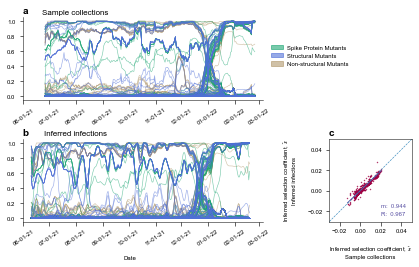

In [9]:
def plot_covar_tricolor(ax, x, y, z, plot_label, start_time, end_time, scalar_map):
    
    # set font param
    mpl.rc('font', family='Arial')
    
    csv_file = os.path.join(data_dir, 'ref-index-2024-01-26.csv')
    ref = pd.read_csv(csv_file)
    df = pd.DataFrame(ref)
    sites = z
    
    NUC     = ['-', 'A', 'C', 'G', 'T']
    new_labels = []
    for i in sites:
        for j in NUC:
            new_labels.append(str(i) + '-' + j)      
    
    index_drop = []
    ref_index_set = set(map(str, sites))
    df = df[df['ref_index'].astype(str).isin(ref_index_set)]
    df = df[~df['ref_index'].isin(index_drop)]
    df['combined'] = df['ref_index'].str.cat(df['nucleotide'], sep='-')

    ref_labels = []
    for i in enumerate(df['combined']):
        ref_labels.append(i[1])
    st = set(ref_labels)
    indices = [i for i, e in enumerate(new_labels) if e in st]

    ref_date = datetime.date(2020, 1, 1)
    x_days = [int(day) for day in x]
    x_dates = [ref_date + datetime.timedelta(days=day) for day in x_days] 
    
    num_lines = y.shape[1]
    
    for i in range(num_lines):
        site_label = new_labels[i]
        # handles reference genome insertion characters (22203a-y)
        if isinstance(site_label, str):
            site_value = int(re.sub(r'\D', '', site_label))
        else:
            site_value = int(site_label)
        
        ### comment one or other out
        # binary based on spike protein sites
        #col = 'xkcd:viridian' if (21562 <= site_value < 25384) else 'xkcd:grayish purple'
        if (21562 <= site_value < 25384):
            col = 'xkcd:jade'
        elif (25384 <= site_value):
            col = 'xkcd:cornflower blue'
        # binary based on structural sites
        #col = 'xkcd:cobalt blue' if (21562 <= site_value) else 'xkcd:orchid'
        else: col = 'xkcd:dust'
        #col = 'xkcd:viridian' if (21562 <= site_value) else 'xkcd:grayish purple'
        
        if i not in indices:
            x_line = x
            y_line = y[:, i]
            ax.plot(x_dates, y_line, linewidth=0.6, color=col, alpha=0.6)

    #plt.subplots_adjust(bottom=0.15)
    
    #ax.set_ylabel('Allele frequency', font='Arial', size=6, labelpad=10)
    
    #ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    
    ax.tick_params(axis='x', labelsize=6, rotation=35, width=0.6)
    ax.tick_params(axis='y', labelsize=6, width=0.6)
    
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Arial')

    #fig.autofmt_xdate()
    
    for line in ['top', 'right']:
        ax.spines[line].set_visible(False)
    for line in ['left', 'bottom']:
        ax.spines[line].set_linewidth(0.5)
    
    plt.setp(ax.get_xticklabels(), ha='center')
    
    start_date = ref_date + datetime.timedelta(int(start_time))
    end_date = ref_date + datetime.timedelta(int(end_time))
    
    ax.set_xlim(start_date, end_date)
    
    ax.set_title(plot_label, x=0.22, y=0.97, fontsize=8)

def figure_tricolor(index, home_dir):
    
    # crawl through directory to plot each region's trajectories
    un_covar_home = os.path.join(home_dir, 'genome-covar')
    bp_covar_home = os.path.join(home_dir, 'bp-covar')
    # from inf_figure function
    sorted_inf_files = sorted(f for f in os.listdir(inf_plot_home) if f != ".DS_Store")
    sorted_bp_files = sorted(f for f in os.listdir(inf_plot_bp_home) if f != ".DS_Store")
    # crawling (cont.)
    un_cov_dir = []
    bp_cov_dir = []

    for d in os.listdir(un_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(un_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            un_cov_dir.append(plot_dir)

    for d in os.listdir(bp_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(bp_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            bp_cov_dir.append(plot_dir)

    un_cov_dir = sorted(un_cov_dir)
    bp_cov_dir = sorted(bp_cov_dir)
    
    # inf file loading    
    inf_file = sorted_inf_files[index]
    x = np.load(os.path.join(inf_plot_home, inf_file), allow_pickle=True)

    inf_bp_file = sorted_bp_files[index]
    y = np.load(os.path.join(inf_plot_bp_home, inf_bp_file), allow_pickle=True)
    
    un_sel = x['selection']
    bp_sel = y['selection']
    
    # covar loading

    un_sel_x, un_sel_y, un_ref_z = load_npz_covar(un_cov_dir[index])
    bp_sel_x, bp_sel_y, bp_ref_z = load_npz_covar(bp_cov_dir[index])
    
    # gridspec parameters
    
    fig = plt.figure(figsize=(DOUBLE_COLUMN, DOUBLE_COLUMN/2))
    gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.14, hspace=0.48)
    
    # Subplots for covariate plots
    ax1 = plt.subplot(gs[0, 0])  # Top-left plot (wide)
    ax2 = plt.subplot(gs[1, 0])  # Bottom-left plot (wide)
    ax3 = plt.subplot(gs[1, 2])  # Bottom-right square plot
    
    ax1.set_xlabel('a', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax2.set_xlabel('b', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax1.xaxis.set_label_position('top')
    ax2.xaxis.set_label_position('top')

    num_lines = un_sel_y.shape[1]
    cmap = plt.get_cmap('Spectral')
    norm = plt.Normalize(0, num_lines - 1)
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)
    
    start = int(input("Enter the start date as integer or 0 for entire trajectory: "))
    end = int(input("Enter the end date as integer or 0 for entire trajectory: "))
    
    if start == 0:
        start = min(min(un_sel_x), min(bp_sel_x)) - 10 # 10 for longer traj, 2 for shorter
    if end == 0:
        end = max(max(un_sel_x), max(bp_sel_x)) + 10

    plot_covar_tricolor(ax1, un_sel_x, un_sel_y, un_ref_z, f'Sample collections', start, end, scalar_map)
    plot_covar_tricolor(ax2, bp_sel_x, bp_sel_y, bp_ref_z, f'Inferred infections', start, end, scalar_map)
    
    plot_inf(ax3, un_sel, bp_sel, index)
    
    # custom legend
    
    spike_patch = mpatches.Patch(color='xkcd:jade', alpha=0.6, label='Spike Protein Mutants')
    struct_patch = mpatches.Patch(color='xkcd:cornflower blue', alpha=0.6, label='Structural Mutants')
    nonstruct_patch = mpatches.Patch(color='xkcd:dust', alpha=0.6, label='Non-structural Mutants')
    handles = [spike_patch, struct_patch, nonstruct_patch]

    #fig.legend(handles=handles, loc='center right', bbox_to_anchor=(1.22, 0.5), ncol=1, frameon=False,fontsize=6)  # Legend on the right side
    
    fig.legend(handles=handles, loc='center right', bbox_to_anchor=(0.75, 0.75), ncol=1, fontsize=6, frameon=False)  # Legend on the right side
    
    fig.supxlabel('Date', fontsize=6, y=-0.05, x=0.31)
    fig.supylabel('c', font='Arial', fontweight='bold', fontsize=10, y=0.45, x=0.70,rotation=0)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=0.8)
    
    #save_path = username + f'/paper-epi-backprojection/figures/supplementary_case_{index}_tricolor_date_rescale_double.pdf'
    #print(f"saving plot to: {save_path}")
    #plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    return fig

fig = figure_tricolor(27, home_dir)

<a id="6"></a>
### gap handling (tricolor plots)

Enter the start date as integer or 0 for entire trajectory: 0
Enter the end date as integer or 0 for entire trajectory: 0
LinregressResult(slope=0.9532976210556817, intercept=0.00014691935322288488, rvalue=0.9757773551497271, pvalue=0.0, stderr=0.0033065366345695255, intercept_stderr=1.405146248148668e-05)


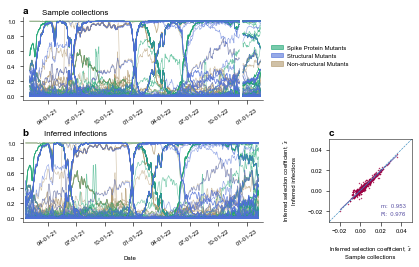

In [10]:
def plot_covar_tricolor_gaps(ax, x, y, z, plot_label, start_time, end_time, scalar_map):
    
    # set font param
    mpl.rc('font', family='Arial')
    
    csv_file = os.path.join(data_dir, 'ref-index-2024-01-26.csv')
    ref = pd.read_csv(csv_file)
    df = pd.DataFrame(ref)
    sites = z
    
    NUC     = ['-', 'A', 'C', 'G', 'T']
    new_labels = []
    for i in sites:
        for j in NUC:
            new_labels.append(str(i) + '-' + j)      
    
    index_drop = []
    ref_index_set = set(map(str, sites))
    df = df[df['ref_index'].astype(str).isin(ref_index_set)]
    df = df[~df['ref_index'].isin(index_drop)]
    df['combined'] = df['ref_index'].str.cat(df['nucleotide'], sep='-')

    ref_labels = []
    for i in enumerate(df['combined']):
        ref_labels.append(i[1])
    st = set(ref_labels)
    indices = [i for i, e in enumerate(new_labels) if e in st]

    ref_date = datetime.date(2020, 1, 1)
    x_days = [int(day) for day in x]
    x_dates = [ref_date + datetime.timedelta(days=day) for day in x_days] 

    
    # masking procedure is manual
    # redo for times?
    ################
    # plot 08    
    #mask_start = datetime.date(2022, 9, 30)
    #mask_end = datetime.date(2022, 10, 5)
    #mask_start_2 = datetime.date(2022, 7, 29)
    #mask_end_2 = datetime.date(2022, 8, 4)
    
    #################
    # plot 38
    mask_start = datetime.date(2022, 12, 9)
    mask_end = datetime.date(2022, 12, 13)
    
    ###########################
    # plot 44
    #mask_start = datetime.date(2022, 7, 2)
    #mask_end = datetime.date(2022, 7, 20)
    
    ############################
    # plot 55
    #mask_start = datetime.date(2021, 4, 28)
    #mask_end = datetime.date(2021, 6, 3)
    

    masked_y = y.copy()
    for i, date in enumerate(x_dates):
        if mask_start <= date <= mask_end:
            masked_y[i, :] = np.nan
        #if mask_start_2 <= date <= mask_end_2:
        #    masked_y[i, :] = np.nan
    ##################
    
    num_lines = y.shape[1]
    
    for i in range(num_lines):
        site_label = new_labels[i]
        # handles reference genome insertion characters (22203a-y)
        if isinstance(site_label, str):
            site_value = int(re.sub(r'\D', '', site_label))
        else:
            site_value = int(site_label)
        
        ### comment one or other out
        # binary based on spike protein sites
        #col = 'xkcd:viridian' if (21562 <= site_value < 25384) else 'xkcd:grayish purple'
        if (21562 <= site_value < 25384):
            col = 'xkcd:jade'
        elif (25384 <= site_value):
            col = 'xkcd:cornflower blue'
        # binary based on structural sites
        #col = 'xkcd:cobalt blue' if (21562 <= site_value) else 'xkcd:orchid'
        else: col = 'xkcd:dust'
        #col = 'xkcd:viridian' if (21562 <= site_value) else 'xkcd:grayish purple'
        
        if i not in indices:
            x_line = x
            y_line = masked_y[:, i]
            ax.plot(x_dates, y_line, linewidth=0.6, color=col, alpha=0.6)

    #plt.subplots_adjust(bottom=0.15)
    
    #ax.set_ylabel('Allele frequency', font='Arial', size=6, labelpad=10)
    
    #ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    
    ax.tick_params(axis='x', labelsize=6, rotation=35, width=0.6)
    ax.tick_params(axis='y', labelsize=6, width=0.6)
    
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Arial')

    #fig.autofmt_xdate()
    
    for line in ['top', 'right']:
        ax.spines[line].set_visible(False)
    for line in ['left', 'bottom']:
        ax.spines[line].set_linewidth(0.5)
    
    plt.setp(ax.get_xticklabels(), ha='center')
    
    start_date = ref_date + datetime.timedelta(int(start_time))
    end_date = ref_date + datetime.timedelta(int(end_time))
    
    ax.set_xlim(start_date, end_date)
    
    ax.set_title(plot_label, x=0.22, y=0.97, fontsize=8)

def figure_tricolor_gaps(index, home_dir):
    
    # crawl through directory to plot each region's trajectories
    un_covar_home = os.path.join(home_dir, 'genome-covar')
    bp_covar_home = os.path.join(home_dir, 'bp-covar')
    # from inf_figure function
    sorted_inf_files = sorted(f for f in os.listdir(inf_plot_home) if f != ".DS_Store")
    sorted_bp_files = sorted(f for f in os.listdir(inf_plot_bp_home) if f != ".DS_Store")
    # crawling (cont.)
    un_cov_dir = []
    bp_cov_dir = []

    for d in os.listdir(un_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(un_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            un_cov_dir.append(plot_dir)

    for d in os.listdir(bp_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(bp_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            bp_cov_dir.append(plot_dir)

    un_cov_dir = sorted(un_cov_dir)
    bp_cov_dir = sorted(bp_cov_dir)
    
    # inf file loading    
    inf_file = sorted_inf_files[index]
    x = np.load(os.path.join(inf_plot_home, inf_file), allow_pickle=True)

    inf_bp_file = sorted_bp_files[index]
    y = np.load(os.path.join(inf_plot_bp_home, inf_bp_file), allow_pickle=True)
    
    un_sel = x['selection']
    bp_sel = y['selection']
    
    # covar loading

    un_sel_x, un_sel_y, un_ref_z = load_npz_covar(un_cov_dir[index])
    bp_sel_x, bp_sel_y, bp_ref_z = load_npz_covar(bp_cov_dir[index])
    
    # gridspec parameters
    
    fig = plt.figure(figsize=(DOUBLE_COLUMN, DOUBLE_COLUMN/2))
    #gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.3, hspace=0.5)
    gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.14, hspace=0.48)
    # Subplots for covariate plots
    ax1 = plt.subplot(gs[0, 0])  # Top-left plot (wide)
    ax2 = plt.subplot(gs[1, 0])  # Bottom-left plot (wide)
    ax3 = plt.subplot(gs[1, 2])  # Bottom-right square plot
    
    ax1.set_xlabel('a', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax2.set_xlabel('b', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax1.xaxis.set_label_position('top')
    ax2.xaxis.set_label_position('top')

    num_lines = un_sel_y.shape[1]
    cmap = plt.get_cmap('Spectral')
    norm = plt.Normalize(0, num_lines - 1)
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)
    
    start = int(input("Enter the start date as integer or 0 for entire trajectory: "))
    end = int(input("Enter the end date as integer or 0 for entire trajectory: "))
    
    if start == 0:
        start = min(min(un_sel_x), min(bp_sel_x)) - 10 # 10 for longer traj to make fig look nice
    if end == 0:
        end = max(max(un_sel_x), max(bp_sel_x)) + 10

    plot_covar_tricolor_gaps(ax1, un_sel_x, un_sel_y, un_ref_z, f'Sample collections', start, end, scalar_map)
    plot_covar_tricolor(ax2, bp_sel_x, bp_sel_y, bp_ref_z, f'Inferred infections', start, end, scalar_map)
    
    plot_inf(ax3, un_sel, bp_sel, index)
    
    # custom legend
    
    spike_patch = mpatches.Patch(color='xkcd:jade', alpha=0.6, label='Spike Protein Mutants')
    struct_patch = mpatches.Patch(color='xkcd:cornflower blue', alpha=0.6, label='Structural Mutants')
    nonstruct_patch = mpatches.Patch(color='xkcd:dust', alpha=0.6, label='Non-structural Mutants')
    handles = [spike_patch, struct_patch, nonstruct_patch]

    #fig.legend(handles=handles, loc='center right', bbox_to_anchor=(1.22, 0.5), ncol=1, frameon=False,fontsize=6)  # Legend on the right side
    
    fig.legend(handles=handles, loc='center right', bbox_to_anchor=(0.75, 0.75), ncol=1, fontsize=6, frameon=False)  # Legend on the right side
    
    fig.supxlabel('Date', fontsize=6, y=-0.05, x=0.31)
    fig.supylabel('c', font='Arial', fontweight='bold', fontsize=10, y=0.45, x=0.70,rotation=0)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=0.8)
    
    #save_path = username + f'/paper-epi-backprojection/figures/supplementary_case_{index}_slovakia.pdf'
    #print(f"saving plot to: {save_path}")
    #plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

fig = figure_tricolor_gaps(38, home_dir)

<a id="7"></a>
### gap handling (spike plots)

Enter the start date as integer or 0 for entire trajectory: 652
Enter the end date as integer or 0 for entire trajectory: 700
LinregressResult(slope=0.955276591778143, intercept=0.0006223131876729804, rvalue=0.8204990361436986, pvalue=0.0, stderr=0.013479160020083526, intercept_stderr=5.0958298119301085e-05)


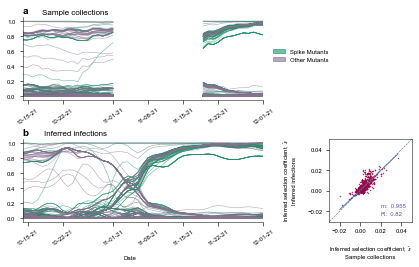

In [13]:
def plot_covar_spike_gaps(ax, x, y, z, plot_label, start_time, end_time, scalar_map):
    
    # set font param
    mpl.rc('font', family='Arial')
    
    csv_file = os.path.join(data_dir, 'ref-index-2024-01-26.csv')
    ref = pd.read_csv(csv_file)
    df = pd.DataFrame(ref)
    sites = z
    
    NUC     = ['-', 'A', 'C', 'G', 'T']
    new_labels = []
    for i in sites:
        for j in NUC:
            new_labels.append(str(i) + '-' + j)      
    
    index_drop = []
    ref_index_set = set(map(str, sites))
    df = df[df['ref_index'].astype(str).isin(ref_index_set)]
    df = df[~df['ref_index'].isin(index_drop)]
    df['combined'] = df['ref_index'].str.cat(df['nucleotide'], sep='-')

    ref_labels = []
    for i in enumerate(df['combined']):
        ref_labels.append(i[1])
    st = set(ref_labels)
    indices = [i for i, e in enumerate(new_labels) if e in st]

    ref_date = datetime.date(2020, 1, 1)
    x_days = [int(day) for day in x]
    x_dates = [ref_date + datetime.timedelta(days=day) for day in x_days] 

    
    # masking procedure is manual
    # redo for times?
    ################
    # plot 08    
    #mask_start = datetime.date(2022, 9, 30)
    #mask_end = datetime.date(2022, 10, 5)
    #mask_start_2 = datetime.date(2022, 7, 29)
    #mask_end_2 = datetime.date(2022, 8, 4)
    
    #plot 11 (South Africa supplementary figure)
    mask_start = datetime.date(2021, 11, 2)
    mask_end = datetime.date(2021, 11, 18)
    
    #################
    # plot 38
    #mask_start = datetime.date(2022, 12, 9)
    #mask_end = datetime.date(2022, 12, 13)
    
    ###########################
    # plot 44
    #mask_start = datetime.date(2022, 7, 2)
    #mask_end = datetime.date(2022, 7, 20)
    
    ############################
    # plot 55
    #mask_start = datetime.date(2021, 4, 28)
    #mask_end = datetime.date(2021, 6, 3)
    

    masked_y = y.copy()
    for i, date in enumerate(x_dates):
        if mask_start <= date <= mask_end:
            masked_y[i, :] = np.nan
        #if mask_start_2 <= date <= mask_end_2:
        #    masked_y[i, :] = np.nan
    ##################
    
    num_lines = y.shape[1]
    
    for i in range(num_lines):
        site_label = new_labels[i]
        # handles reference genome insertion characters (22203a-y)
        if isinstance(site_label, str):
            site_value = int(re.sub(r'\D', '', site_label))
        else:
            site_value = int(site_label)
        
        ### comment one or other out
        # binary based on spike protein sites
        col = 'xkcd:viridian' if (21562 <= site_value < 25384) else 'xkcd:grayish purple'
        
        if i not in indices:
            x_line = x
            y_line = masked_y[:, i]
            ax.plot(x_dates, y_line, linewidth=0.6, color=col, alpha=0.6)

    #plt.subplots_adjust(bottom=0.15)
    
    #ax.set_ylabel('Allele frequency', font='Arial', size=6, labelpad=10)
    
    #ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
    
    ax.tick_params(axis='x', labelsize=6, rotation=35, width=0.6)
    ax.tick_params(axis='y', labelsize=6, width=0.6)
    
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Arial')

    #fig.autofmt_xdate()
    
    for line in ['top', 'right']:
        ax.spines[line].set_visible(False)
    for line in ['left', 'bottom']:
        ax.spines[line].set_linewidth(0.5)
    
    plt.setp(ax.get_xticklabels(), ha='center')
    
    start_date = ref_date + datetime.timedelta(int(start_time))
    end_date = ref_date + datetime.timedelta(int(end_time))
    
    ax.set_xlim(start_date, end_date)
    
    ax.set_title(plot_label, x=0.22, y=0.97, fontsize=8)

def figure_spike_gaps(index, home_dir):
    
    # crawl through directory to plot each region's trajectories
    un_covar_home = os.path.join(home_dir, 'genome-covar')
    bp_covar_home = os.path.join(home_dir, 'bp-covar')
    # from inf_figure function
    sorted_inf_files = sorted(f for f in os.listdir(inf_plot_home) if f != ".DS_Store")
    sorted_bp_files = sorted(f for f in os.listdir(inf_plot_bp_home) if f != ".DS_Store")
    # crawling (cont.)
    un_cov_dir = []
    bp_cov_dir = []

    for d in os.listdir(un_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(un_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            un_cov_dir.append(plot_dir)

    for d in os.listdir(bp_covar_home):
        if ".DS_Store" in d:
            continue
        sub_dir = os.path.join(bp_covar_home, d)
        for sd in os.listdir(sub_dir):
            if ".DS_Store" in sd:
                continue
            plot_dir = os.path.join(sub_dir, sd)
            bp_cov_dir.append(plot_dir)

    un_cov_dir = sorted(un_cov_dir)
    bp_cov_dir = sorted(bp_cov_dir)
    
    # inf file loading    
    inf_file = sorted_inf_files[index]
    x = np.load(os.path.join(inf_plot_home, inf_file), allow_pickle=True)

    inf_bp_file = sorted_bp_files[index]
    y = np.load(os.path.join(inf_plot_bp_home, inf_bp_file), allow_pickle=True)
    
    un_sel = x['selection']
    bp_sel = y['selection']
    
    # covar loading

    un_sel_x, un_sel_y, un_ref_z = load_npz_covar(un_cov_dir[index])
    bp_sel_x, bp_sel_y, bp_ref_z = load_npz_covar(bp_cov_dir[index])
    
    # gridspec parameters
    
    fig = plt.figure(figsize=(DOUBLE_COLUMN, DOUBLE_COLUMN/2))
    #gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.3, hspace=0.5)
    gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.2, 2], height_ratios=[1, 1], wspace=0.14, hspace=0.48)
    # Subplots for covariate plots
    ax1 = plt.subplot(gs[0, 0])  # Top-left plot (wide)
    ax2 = plt.subplot(gs[1, 0])  # Bottom-left plot (wide)
    ax3 = plt.subplot(gs[1, 2])  # Bottom-right square plot
    
    ax1.set_xlabel('a', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax2.set_xlabel('b', font='Arial', fontweight='bold', size=10, labelpad=4, loc='left')
    ax1.xaxis.set_label_position('top')
    ax2.xaxis.set_label_position('top')

    num_lines = un_sel_y.shape[1]
    cmap = plt.get_cmap('Spectral')
    norm = plt.Normalize(0, num_lines - 1)
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)
    
    start = int(input("Enter the start date as integer or 0 for entire trajectory: "))
    end = int(input("Enter the end date as integer or 0 for entire trajectory: "))
    
    if start == 0:
        start = min(min(un_sel_x), min(bp_sel_x)) - 2 # 10 for longer traj to make fig look nice
    if end == 0:
        end = max(max(un_sel_x), max(bp_sel_x)) + 2

    plot_covar_spike_gaps(ax1, un_sel_x, un_sel_y, un_ref_z, f'Sample collections', start, end, scalar_map)
    plot_covar_spike(ax2, bp_sel_x, bp_sel_y, bp_ref_z, f'Inferred infections', start, end, scalar_map)
    
    plot_inf(ax3, un_sel, bp_sel, index)
    
    # custom legend
    
    
    spike_patch = mpatches.Patch(color='xkcd:viridian', label='Spike Mutants', alpha = 0.6)
    other_patch = mpatches.Patch(color='xkcd:grayish purple', label='Other Mutants', alpha = 0.6)
    handles = [spike_patch, other_patch]

    #fig.legend(handles=handles, loc='center right', bbox_to_anchor=(1.22, 0.5), ncol=1, frameon=False,fontsize=6)  # Legend on the right side
    
    fig.legend(handles=handles, loc='center right', bbox_to_anchor=(0.71, 0.75), ncol=1, fontsize=6, frameon=False)  # Legend on the right side

    fig.supxlabel('Date', fontsize=6, y=-0.05, x=0.31)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=0.8)
    
    #save_path = username + f'/paper-epi-backprojection/figures/supplementary_case_{index}_spike_date_rescale_gaps.pdf'
    #print(f"saving plot to: {save_path}")
    #plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

fig = figure_spike_gaps(11, home_dir)